<a href="https://colab.research.google.com/github/MScaramuzzi/A1-RNNs-for-Sequence-Labeling/blob/main/Ass_1_DEFINITIVO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1

**Due to**: 11/01/2023 (dd/mm/yyyy)

**Credits**: Andrea Galassi, Federico Ruggeri, Paolo Torroni

**Summary**: Part-of Speech (POS) tagging as Sequence Labelling using Recurrent Neural Architectures

**Authors**:

* Sergio Barezzani: sergio.barezzani@studio.unibo.it
* Giuseppe Morgese: giuseppe.morgese2@studio.unibo.it
* Marco Scaramuzzi: marco.scaramuzzi@studio.unibo.it

**Task**: given a corpus of documents, predict the POS tag for each word

**Corpus**: Ignore the numeric value in the third column, use only the words/symbols and its label. The corpus is available at: https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip

Importing and installing useful libraries

In [ ]:
!pip3 install keras_tuner
!pip install keras-tuner tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.0 MB/s eta 0:00:00


In [ ]:
import urllib.request  #  download files
import tarfile  #  unzip files
import shutil
import os
import urllib.request  #  download files
import zipfile  #  unzip files
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
import tensorflow as tf
import keras_tuner as kt
from keras.optimizers import Adam
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import L2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer,Dropout, LSTM, Bidirectional, GRU, Dense, TimeDistributed, Activation,Masking
from keras_tuner import RandomSearch, Objective
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score,classification_report,accuracy_score
from keras.utils.vis_utils import plot_model

#### Ensuring reproducibility

In [ ]:
def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
set_reproducibility(42)

## 1. Download the corpora and split it in training and test sets, structuring a dataframe.




**Splits**: documents 1-100 are the train set, 101-150 validation set, 151-199 test set.

**Splitting**: you can decide to split documents into sentences or not, the choice is yours.


**I/O structure**: The input data will have three dimensions: 1-documents/sentences, 2-token, 3-features; for the output there are 2 possibilities: if you use one-hot encoding it will be 1-documents/sentences, 2-token labels, 3-classes, if you use a single integer that indicates the number of the class it will be 1-documents/sentences, 2-token labels.

#### Dataset downloading

In [ ]:
data_folder = os.path.join(os.getcwd(), "Documents")

if not os.path.exists(data_folder):
    os.makedirs(data_folder)

url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"

dataset_path = os.path.join(data_folder, "dependency_treebank.zip")

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)
    print("Successful download")

with zipfile.ZipFile(dataset_path,"r") as zip_ref:
    zip_ref.extractall("Documents")

docs_folder = os.path.join(data_folder, "dependency_treebank")

print("Successful extraction")

Successful download
Successful extraction


Changing the directory the the one of the data 

In [ ]:
os.chdir(docs_folder)

In [ ]:
# Retrieving file names
data = []

for filename in sorted(os.listdir(docs_folder)):
        data.append(filename)

train_files, val_files, test_files = data[0:100],data[100:150],data[150:200]
file_names = train_files+ val_files+ test_files

In [ ]:
def extract_data(files):
    """
    With this function we create an array of arrays for the tokens and 
    an array of arrays for the tags.
    """
    sentences = []
    tags_sents = []
    for file in files:
        with open(file, mode="r", encoding="utf-8") as file_str:
            tkns = []
            tags = []
            for line in file_str.readlines():
                if line.strip() == "": # retrieve end of line 
                            sentences.append(np.array(tkns))
                            tags_sents.append(np.array(tags))
                            tkns = []
                            tags = []
                else:
                    # add token to sentence if the line is not empty 
                    token, tag, _ = line.split("\t")
                    tkns.append(token.lower())
                    tags.append(tag)
            sentences.append(np.array(tkns))
            tags_sents.append(np.array(tags))
    return np.array(sentences,dtype=object), np.array(tags_sents,dtype=object)

In [ ]:
X_train_sents, y_train_tags = extract_data(train_files)
X_val_sents, y_val_tags = extract_data(val_files)
X_test_sents, y_test_tags = extract_data(test_files)

### Dataframe creation

In [ ]:
# Creating the structure of the dataframe rows
dataframe_rows = {
    'sentences': np.concatenate([X_train_sents, X_val_sents, X_test_sents],axis=0),
    'tags':np.concatenate([y_train_tags, y_val_tags, y_test_tags],axis=0) 
}

In [ ]:
df = pd.DataFrame(dataframe_rows)
df.head(10)

,sentences,tags
0,"[pierre, vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ..."
1,"[mr., vinken, is, chairman, of, elsevier, n.v....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ..."
2,"[rudolph, agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP..."
3,"[a, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS..."
4,"[the, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V..."
5,"[lorillard, inc., ,, the, unit, of, new, york-...","[NNP, NNP, ,, DT, NN, IN, JJ, JJ, NNP, NNP, WD..."
6,"[although, preliminary, findings, were, report...","[IN, JJ, NNS, VBD, VBN, RBR, IN, DT, NN, IN, ,..."
7,"[a, lorillard, spokewoman, said, ,, ``, this, ...","[DT, NNP, NN, VBD, ,, ``, DT, VBZ, DT, JJ, NN, .]"
8,"[we, 're, talking, about, years, ago, before, ...","[PRP, VBP, VBG, IN, NNS, IN, IN, NN, VBD, IN, ..."
9,"[there, is, no, asbestos, in, our, products, n...","[EX, VBZ, DT, NN, IN, PRP$, NNS, RB, ., '']"


Dataframe inspection

In [ ]:
print(f'Dataset shape: {df.shape} \n')

print(f'Dataset columns: {df.columns.values} \n')

print('Dataset Head: \n')
print("-"*50)
display(df.head())

Dataset shape: (3914, 2) 

Dataset columns: ['sentences' 'tags'] 

Dataset Head: 

--------------------------------------------------


,sentences,tags
0,"[pierre, vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ..."
1,"[mr., vinken, is, chairman, of, elsevier, n.v....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ..."
2,"[rudolph, agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP..."
3,"[a, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS..."
4,"[the, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V..."


### Data exploration
We now wish to understand the structure of the data before encoding it with the GloVe embedding and one-hot encoding the labels. 

We are going to perform some visualization of the distribution of the **tags** in order to make error  analysis more robust.

In [ ]:
# Counting the sentences of each sets
print(f"- Sentences in the train set: {X_train_sents.shape[0]} sentences")
print(f"- Sentences in the validation set: {X_val_sents.shape[0]} sentences")
print(f"- Sentences in the test set: {X_test_sents.shape[0]} sentences")

- Sentences in the train set: 1963 sentences
- Sentences in the validation set: 1299 sentences
- Sentences in the test set: 652 sentences


In [ ]:
print(f"Example structure of the arrays: \n {X_train_sents[0:5]} ")

Example structure of the arrays: 
 [array(['pierre', 'vinken', ',', '61', 'years', 'old', ',', 'will', 'join',
        'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.',
        '29', '.'], dtype='<U12')
 array(['mr.', 'vinken', 'is', 'chairman', 'of', 'elsevier', 'n.v.', ',',
        'the', 'dutch', 'publishing', 'group', '.'], dtype='<U10')
 array(['rudolph', 'agnew', ',', '55', 'years', 'old', 'and', 'former',
        'chairman', 'of', 'consolidated', 'gold', 'fields', 'plc', ',',
        'was', 'named', 'a', 'nonexecutive', 'director', 'of', 'this',
        'british', 'industrial', 'conglomerate', '.'], dtype='<U12')
 array(['a', 'form', 'of', 'asbestos', 'once', 'used', 'to', 'make',
        'kent', 'cigarette', 'filters', 'has', 'caused', 'a', 'high',
        'percentage', 'of', 'cancer', 'deaths', 'among', 'a', 'group',
        'of', 'workers', 'exposed', 'to', 'it', 'more', 'than', '30',
        'years', 'ago', ',', 'researchers', 'reported', '.'], dtype='<U11')
 ar

The structure is an array (`X_train_sents`) of arrays. The elements of each subarray are the words in each sentence). 

In [ ]:
print("Example of a document: ", ' '.join(X_val_sents[13]))
print("Example tags: ", (y_val_tags[13]))

Example of a document:  the potential sales are nearly $ 9.3 million , and house majority whip william gray -lrb- d. , pa . -rrb- began the bidding this year by proposing language that the quota be allocated to english-speaking countries of the caribbean , such as jamaica and barbados .
Example tags:  ['DT' 'JJ' 'NNS' 'VBP' 'RB' '$' 'CD' 'CD' ',' 'CC' 'NNP' 'NNP' 'NNP' 'NNP'
 'NNP' '-LRB-' 'NNP' ',' 'NNP' '.' '-RRB-' 'VBD' 'DT' 'NN' 'DT' 'NN' 'IN'
 'VBG' 'NN' 'IN' 'DT' 'NN' 'VB' 'VBN' 'TO' 'JJ' 'NNS' 'IN' 'DT' 'NNP' ','
 'JJ' 'IN' 'NNP' 'CC' 'NNP' '.']


From the above example we can see that in order to reduce the number of tokens in the OOV dictionaries we have lowercased every word. 

Later we will need to deal with removing ALL the tags that are non explicitly a word (so symbols and punctuation).

In [ ]:
all_tags = np.concatenate(np.concatenate([y_train_tags,y_val_tags,y_test_tags])) # flatten tag subarrays

In [ ]:
tags, counts = list(np.unique(all_tags, return_counts=True)) # count instances of each single tag
tags_cnt= dict(zip(tags,counts))                              # merge tags and counts into a dictionary

print("The ten most frequent tags are: ")
sorted_tags = dict(sorted(tags_cnt.items(), key=lambda item: item[1],reverse=True))
print(list(sorted_tags.items())[0:10])

The ten most frequent tags are: 
[('NN', 13166), ('IN', 9857), ('NNP', 9410), ('DT', 8165), ('NNS', 6047), ('JJ', 5834), (',', 4886), ('.', 3874), ('CD', 3546), ('VBD', 3043)]


As expected the most frequent tags are such as nouns(NN,NNP,NNS),adverbs(JJ), determiners(DT) and punctation.

### Understanding content of tag arrays

We need to flatten each arrays with concatenate and then calculate the number of unique tags.

In [ ]:
unique_tags_train = np.unique(np.concatenate(y_train_tags))
unique_tags_val = np.unique(np.concatenate(y_val_tags))
unique_tags_test = np.unique(np.concatenate(y_test_tags))

In [ ]:
print(f"- Unique tags in train set: {len(unique_tags_train)} tags \n")
print(f"- Unique tags in validation set: {len(unique_tags_val)} tags \n")
print(f"- Unique tags in test set: {len(unique_tags_test)} tags")

- Unique tags in train set: 45 tags 

- Unique tags in validation set: 44 tags 

- Unique tags in test set: 40 tags


In [ ]:
print("- Tags that are present in the train set and are not present in the validation set:",list(set(unique_tags_train).difference(set(unique_tags_val))))
print()
print("- Tags that are present in the train set and are not present in the test set:",list(set(unique_tags_train).difference(set(unique_tags_test))))
print()
print("- Tags that are present in the validation set and are not present in the test set:",list(set(unique_tags_val).difference(set(unique_tags_test))))

- Tags that are present in the train set and are not present in the validation set: ['SYM']

- Tags that are present in the train set and are not present in the test set: ['LS', 'SYM', '#', 'FW', 'UH']

- Tags that are present in the validation set and are not present in the test set: ['LS', 'UH', '#', 'FW']


### Getting max sentence length

We need to retrieve the maximum sentence lenght in order to perform the correct encoding of the data with the necessary padding. 

Each sentence has different lenght therefore we need to encode each sentence with the maximum size possible.

In [ ]:
print(f"Max sentence length is: {df.sentences.str.len().max()}")

Max sentence length is: 249


In [ ]:
max_size = 250

### Retrieving punctuation indices 

This will be useful later for error analysis

In [ ]:
sort_tags = np.array(sorted(unique_tags_train))

In [ ]:
sort_tags = np.append(sort_tags,'UNK')

In [ ]:
print(sort_tags)

['#' '$' "''" ',' '-LRB-' '-RRB-' '.' ':' 'CC' 'CD' 'DT' 'EX' 'FW' 'IN'
 'JJ' 'JJR' 'JJS' 'LS' 'MD' 'NN' 'NNP' 'NNPS' 'NNS' 'PDT' 'POS' 'PRP'
 'PRP$' 'RB' 'RBR' 'RBS' 'RP' 'SYM' 'TO' 'UH' 'VB' 'VBD' 'VBG' 'VBN' 'VBP'
 'VBZ' 'WDT' 'WP' 'WP$' 'WRB' '``' 'UNK']


COMPLETA QUESTO

UNK is last for generalization purposes of the encoding approach. We have used it even though it will not be employed in the assignment for .... purposes.

### Understanding punctuation and symbols

We need to the remove the indices associated with the following symbols:

* Punctuation:
  - -LRB- &rarr; "Left Round Bracket" &rarr; "({"
  - -RRB- &rarr; "Right Round Bracket" &rarr; "){"
  - # 
  - $
  - ' ' 
  - , 
  - . 
  - : 


* Symbols:

  - LS &rarr; List item marker
  - SYM &rarr; Symbol
  - ``

In [ ]:
indices = [0, 1, 2, 3, 4, 5, 6,7, 17, 31, 44] # symbols and punctuation
print("Displaying the tags to remove and their associated index: \n")
print(dict(zip(sort_tags[indices],indices)))

Displaying the tags to remove and their associated index: 

{'#': 0, '$': 1, "''": 2, ',': 3, '-LRB-': 4, '-RRB-': 5, '.': 6, ':': 7, 'LS': 17, 'SYM': 31, '``': 44}


## Encoding the dataset


Generating embedding dictionary for GloVe 

In [ ]:
# Download the GloVe embeddings
!gdown https://nlp.stanford.edu/data/glove.6B.zip

# Unzip the GloVe embeddings file
!unzip -q -o glove.6B.zip -d embeddings

Downloading...
From: https://nlp.stanford.edu/data/glove.6B.zip
To: /content/Documents/dependency_treebank/glove.6B.zip
100% 862M/862M [02:39<00:00, 5.42MB/s]


We choose an embedding dimension of size 100d in order to have a good tradeoff between performance and time spent training.

It is also possible to experiment with other sizes such as 50,200 or 300. Through experimenting we have found that 100 is enough for our purposes.

In [ ]:
""" 
Retrieving GloVe embedding from file and then generating a dictionary
where each word is a key and the value is the embedding vector. 
"""
V1 = {}
with open(docs_folder+"/embeddings/glove.6B.100d.txt", 'r') as f:
    for line in f:
        vals = line.split()
        token = vals[0]
        embedding = np.asarray(vals[1:], "float32")
        V1[token] = embedding

### OOV handling

The OOV words will be assigned a random embedding sampled from uniform distribution, in the range `[-0.5,+0.5]` in order to match it with the numerical range of GloVe embeddings. It is also possible to experiment with other types of embedding for OOV.

In [ ]:
embedding_dim = 100 # chosen as compromise between time spent training and performance

UNIFORM BECAUSE WE DO NOT KNOW THE SHAPE OF EMBEDDINGS ( have no idea of mean and std to use gaussian)

In [ ]:
def generate_oov(emb_dictionary, tokens,embedding_dim):
    """
    Checks whether a token is not present in the vocabulary containing the embeddings,
    if it is not present, then insert it in the dictionary of the OOV words with a random value
    sampled from an uniform distribution in the correct range of values (the one of glove embeddings).
    """
    oov_dict = {} # create oov dict
    for token in tokens: 
        if token not in emb_dictionary:
            oov_dict[token]= np.random.uniform(-0.5, 0.5, size=embedding_dim)
    return oov_dict

In [ ]:
# Flatten the arrays of each data split to get all the tokens 
train_toks = np.concatenate(np.concatenate([X_train_sents]))
val_toks = np.concatenate(np.concatenate([X_val_sents]))
test_toks = np.concatenate(np.concatenate([X_test_sents]))

In [ ]:
# From the above flattened arrays retrieve the unique tags 
unique_train_toks = np.unique(train_toks)
unique_val_toks = np.unique(val_toks)
unique_test_toks = np.unique(test_toks)


We now need to encode the features and the labels in numeric format in order to be able to process it with a neural network. 

* The features (*X_train_sents* and all others features arrays) will be encoded through a GloVe embedding if they are in the dictionary. If they are OOV they will be encoded with a random value sampled from an uniform distribution.
    * the *X_train_sents* array has a structure of being an array of arrays with only one dimension. We wish to encode this in a 3D format with the following shape:

    ```
    (number_of_sentences,max_sentence_lenght,embedding_dimension)
    ```

## Another way of embedding could have been to use a Co-Occurrance matrix (METTI SPIEGAZIONE CLAUDIO BON ETC.)

In [ ]:
# Defining an helper function for padding the y_tags later

"""
This function uses numpy padding on an input array and pads it with a custom defined
padding. In our case it is an array of zeros which shape that is based on the difference
between the max lenght of a sentence (250) and the actual shape of the sentence.
"""

def pad(array, target_shape):
    return np.pad(array,
        [(0, target_shape[i] - array.shape[i]) for i in range(len(array.shape))],
        "constant",
    )

In [ ]:
# encode each word of a sentence in a numpy array
def encode_sentence(sentence,vocab):
    return np.array([vocab[token] for token in sentence])

In [ ]:
"""
this function uses the above defined function to encode each word in a sentence 
and then appending it to an array, then this array is constructed with the right shape defined above.

the padding size is used for making a sentence reach the maximum lenght(250)
and to have the correct shape we need for our analysis(100).
"""
def encode_features(array,vocabulary):
  transf_sentence = []
  for sentence in array:
    pad_size = (max_size-len(sentence), embedding_dim)
    encoded = encode_sentence(sentence,vocabulary) 
    transf_sentence.append(
              np.row_stack((encoded, np.zeros(pad_size)))
            )
  return np.array(transf_sentence)

### Handling of OOV tokens

We proceeded to perform the OOV encoding as per requested by the assignment request.

1. Starting vocabulary *V1* (in this assignment, GloVe vocabulary)
2. Compute embeddings for terms out of vocabulary *OOV1* of the training split
3. Add embeddings to the vocabulary, so to obtain vocabulary *V2* which is the concatenation of *V1* and *OOV1*
4. Compute embeddings for terms  of the validation split *OOV2*
5. Add embeddings to the vocabulary, so to obtain vocabulary *V3* = *V2* + *OOV2*
6. Compute embeddings for terms  of the test split *OOV3*
7. Add embeddings to the vocabulary, so to obtain vocabulary *V4* = *V3* + *OOV3*

In [ ]:
print("- Generating the OOV for train set... \n")
OOV1 = generate_oov(V1,unique_train_toks,embedding_dim)


print("- Merging initial vocabulary and OOV1... ")
V2 = {**V1,**OOV1} # using dictionary synthax to merge dictionaries
X_train= encode_features(X_train_sents,V2)
print(f"\n- Shape of the training set: {X_train.shape} \n")

print("- Generating the OOV for validation set... \n")
OOV2 = generate_oov(V2,unique_val_toks,embedding_dim)

print("- Merging V2 and OOV2: ")
V3 = {**V2,**OOV2}
X_val= encode_features(X_val_sents,V3)
print(f"\n- Shape of the validation set: {X_val.shape} \n")

print("- Generating the OOV for test set... \n")
OOV3 = generate_oov(V3,unique_test_toks,embedding_dim)

print("- Merging V4 and OOV4... ")
V4 = {**V3,**OOV3}
X_test= encode_features(X_test_sents,V4)
print(f"\n- Shape of the test set: {X_test.shape} \n")

- Generating the OOV for train set... 

- Merging initial vocabulary and OOV1... 

- Shape of the training set: (1963, 250, 100) 

- Generating the OOV for validation set... 

- Merging V2 and OOV2: 

- Shape of the validation set: (1299, 250, 100) 

- Generating the OOV for test set... 

- Merging V4 and OOV4... 

- Shape of the test set: (652, 250, 100) 



Retrieve the OOV sets and then use a set data structure for storing it.

In [ ]:
train_oov_terms = set(OOV1.keys())
val_oov_terms = set(OOV2.keys())
test_oov_terms = set(OOV3.keys())

Get the OOV terms unique for the val set and the test set.

In [ ]:
val_only_oov_terms = val_oov_terms - train_oov_terms
test_only_oov_terms = test_oov_terms - train_oov_terms - val_oov_terms

Check the percentage of OOV for each data split.

In [ ]:
print(
    f"Total training OOV terms: {len(train_oov_terms)} words, {round(len(train_oov_terms) / len(unique_train_toks), 2)}% of the total train set tags")

print(
    f"Total validation OOV terms: {len(val_only_oov_terms)} words, {round(len(val_only_oov_terms) / len(unique_val_toks), 2)}% of the total validation set tags")

print(
    f"Total testing OOV terms: {len(test_only_oov_terms)} words, {round(len(test_only_oov_terms) / len(unique_test_toks), 2)}% of the total test set tags")

Total training OOV terms: 359 words, 0.05% of the total train set tags
Total validation OOV terms: 189 words, 0.03% of the total validation set tags
Total testing OOV terms: 128 words, 0.04% of the total test set tags


The percentage of OOV for each data split is negligible, let's inspect content of OOV arrays.

In [ ]:
print("- Train set OOV words:",list(OOV1.keys()))
print()
print("- Validation set OOV words:",list(OOV2.keys()))
print()
print("- Test set OOV words:",list(OOV3.keys()))

- Train set OOV words: ['-lcb-', '-lrb-', '-rcb-', '-rrb-', '1.457', '1.5755', '1.8415', '100,980', '11,762', '12,252', '127.03', '13,056', '14,821', '142.85', '143.08', '143.80', '143.93', '16,072', '16.125', '18,444', '1\\/10th', '1\\/2', '1\\/4', '2,303,328', '230-215', '234.4', '236.74', '236.79', '2645.90', '271,124', '278.7', '3,288,453', '3.253', '30,841', '3057', '352.7', '361,376', '37-a-share', '374.19', '374.20', '38.375', '382-37', '3\\/4', '4,393,237', '4.898', '415.6', '415.8', '436.01', '446.62', '449.04', '456.64', '497.34', '5.276', '500,004', '520-lawyer', '5\\/8', '62%-owned', '62.625', '69-point', '70-a-share', '705.6', '737.5', '7\\/8', '82,389', '8300s', '84-month', '9,118', '90-cent-an-hour', '95,142', 'abortion-related', 'ac-130u', 'achievement-test', 'akerfeldt', 'alurralde', 'amphobiles', 'anti-abortionists', 'anti-china', 'anti-takeover', 'antitrust-law', 'ariail', 'aslacton', 'asset-sale', 'autions', 'auto-safety', 'automotive-lighting', 'automotive-parts', 

We can see that most of the OOV words are numbers and composite words. Also there is a POS wrongly represented in the sentence ( the word 'lrb' is present in the GloVe embedding instead '-lcb-' is not). 

We will not pre-process these OOV words  given that they are very infrequent.

###  One Hot Encoding of POS Tags


The task to the performed by the model is a multi-class classification therefore the labels are not encoded assigning integer values to each different class, but rather by one hot encoding.

* The labels (*y_train_tags* and all others labels arrays) will be one hot encoded and will need to have the following shape:

    ```
    (number_of_sentences,max_sentence_lenght,number_of_tags )
    ```

In [ ]:
ohe = OneHotEncoder(sparse=False) # Get one hot encoding for POS tags in the training dataset
ohe.fit(sort_tags.reshape(-1,1))

OneHotEncoder(sparse=False)

In [ ]:
max_tags = len(sort_tags) 

In [ ]:
"""
This function 
array: Input array should be the an array 
which contains the tags of each sentence that will be one hot encoded

max_size is the max sentence lenght: 250
max_tags is the maximum number of tags: 46
"""

def ohe_convert_shape(array):
    result = []
    for i,tags in enumerate(array):
        encoded = ohe.transform(tags.reshape(-1,1))
        padding = (max_size,max_tags)
        result.append(pad(encoded,padding))
    return np.array(result)

In [ ]:
y_train = ohe_convert_shape(y_train_tags)
y_val = ohe_convert_shape(y_val_tags)
y_test = ohe_convert_shape(y_test_tags)

### Displaying the OneHotEncoded arrays

In [ ]:
print(X_train_sents[0])
print()
print(y_train_tags[0])
print("\nDisplaying One Hot Encoding of the first words in the first sentence of the train set:\n")

print(f"\nEncoding of first tag: {y_train_tags[0][0]}")
print(y_train[0][0])
print()
print(f"Encoding of second tag: {y_train_tags[0][1]}")
print(y_train[0][1])
print()
print(f"Encoding of the third tag: {y_train_tags[0][2]}")
print(y_train[0][2])


['pierre' 'vinken' ',' '61' 'years' 'old' ',' 'will' 'join' 'the' 'board'
 'as' 'a' 'nonexecutive' 'director' 'nov.' '29' '.']

['NNP' 'NNP' ',' 'CD' 'NNS' 'JJ' ',' 'MD' 'VB' 'DT' 'NN' 'IN' 'DT' 'JJ'
 'NN' 'NNP' 'CD' '.']

Displaying One Hot Encoding of the first words in the first sentence of the train set:


Encoding of first tag: NNP
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Encoding of second tag: NNP
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Encoding of the third tag: ,
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


The first two tags have the same one hot encoding given that they are NNP. The third tag is a comma and it is represented with a different encoding.

In [ ]:
print(f"- Shape of the train set: {y_train.shape}")
print()
print(f"- Shape of the validation set: {y_val.shape}")
print()
print(f"- Shape of the test set: {y_test.shape}")

- Shape of the train set: (1963, 250, 46)

- Shape of the validation set: (1299, 250, 46)

- Shape of the test set: (652, 250, 46)


# 3. Modeling




### Architectures used:
#### Baseline model
* Bidirectional LSTM + Dense layer 

#### Variations
* Bidirectional GRU + Dense layer
* Two Bidirectional LSTM + Dense layer
* Bidirectional LSTM + Two Dense layer

In [ ]:
n_classes = y_train.shape[2] # 46 tags

In [ ]:
f1 = tfa.metrics.F1Score(num_classes = n_classes, name = 'f1_score')

indices = [0, 1, 2, 3, 4, 5, 6, 7, 17, 31, 44] 

def compute_f1(groundtruth, prediction):
    """
    Computes the F1 score. As requested, the punctuation is ignored.
    """
    groundtruth = tf.reshape(groundtruth, (-1, n_classes))

    punctuation = tf.gather(groundtruth, indices, axis=-1)

    mask = tf.cast(tf.logical_not(tf.reduce_any(tf.cast(punctuation, tf.bool), axis=-1)), tf.float32)
    
    prediction = tf.reshape(prediction, (-1, n_classes))
    
    f1.update_state(groundtruth, prediction, sample_weight = mask)
    
    result = f1.result()
    
    K.batch_set_value([(v, np.zeros(v.shape.as_list())) for v in f1.variables])
    return K.sum(result)/(n_classes-len(indices))

## Baseline model

### Model 1: BiLSTM with a Dense layer

Below we define the model architecture with some hyperparameter specified. The Masking layers is useful for ignoring the padding of the X array.

In [ ]:
  # Define the model architecture
def BiLSTM(hp):
    model = Sequential()
    model.add(Masking(name='padding_x', mask_value=0., input_shape=X_train.shape[1:]))
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=64, max_value=256, step=64),kernel_regularizer=keras.regularizers.l2(0.01), return_sequences=True,name="bilstm_1")))
    model.add(Dropout(rate=hp.Float('dropout',min_value=0.0,max_value=0.5,default=0.2,step=0.1)))
    model.add(TimeDistributed(Dense(n_classes, activation="softmax", name="dense_1")))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), 
                loss='categorical_crossentropy', metrics=['categorical_accuracy',compute_f1])
    return model

## Other models

### Model 2: GRU

In [ ]:
# Create BiGRU and Dense layer
def BiGRU(hp):
    model = Sequential()
    model.add(Masking(name='padding', mask_value=0., input_shape=X_train.shape[1:]))
    model.add(Bidirectional(GRU(units=hp.Int('units', min_value=64, max_value=256, step=64),kernel_regularizer=keras.regularizers.l2(0.01), return_sequences=True,name="gru_1")))
    model.add(Dropout(rate=hp.Float('dropout',min_value=0.0,max_value=0.5,default=0.2,step=0.1)))   
    model.add(TimeDistributed(Dense(n_classes, activation="softmax", name="dense_1")))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), 
                loss='categorical_crossentropy', metrics=['categorical_accuracy',compute_f1])
    return model

### Model 3: Double BILSTM

In [ ]:
# Create model with two BiLSTM layers and Dense layer
def double_BiLSTM(hp):
    model = Sequential()
    model.add(Masking(name='padding', mask_value=0., input_shape=X_train.shape[1:]))
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=64, max_value=256, step=64),kernel_regularizer=keras.regularizers.l2(0.01), return_sequences=True,name="bilstm_1")))
    model.add(Bidirectional(LSTM(units=hp.Int('units2', min_value=64, max_value=256, step=64),kernel_regularizer=keras.regularizers.l2(0.01), return_sequences=True,name="bilstm_2")))
    model.add(Dropout(rate=hp.Float('dropout',min_value=0.0,max_value=0.5,default=0.2,step=0.1)))   
    model.add(TimeDistributed(Dense(n_classes, activation="softmax", name="dense_1")))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), 
                loss='categorical_crossentropy', metrics=['categorical_accuracy',compute_f1])
    return model

### Model 4: BILSTM + Double Dense Layer

In [ ]:
# Create model with one BiLSTM layers and two Dense layers
def bilstm_double_dense(hp):
    model = Sequential()
    model.add(Masking(name='padding', mask_value=0., input_shape=X_train.shape[1:]))
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=64, max_value=256, step=64),kernel_regularizer=keras.regularizers.l2(0.01), return_sequences=True,name="bilstm_1")))
    model.add(Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.5,default=0.2,step=0.1)))      
    model.add(TimeDistributed(Dense(units=hp.Int('units2', min_value=64, max_value=256, step=64),activation="relu",name="dense_1")))
    model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.5,default=0.2,step=0.1)))   
    model.add(TimeDistributed(Dense(n_classes, activation="softmax", name="dense_2")))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), 
                loss='categorical_crossentropy', metrics=['categorical_accuracy',compute_f1])
    return model

## 3.2 Hyperparameter tuning

### Model 1: BILSTM with a Dense layer 

In [ ]:
# Hyperparameter optimization using random search
tuner_bilstm = RandomSearch(BiLSTM, objective = Objective('val_compute_f1', direction = 'max'), max_trials = 4, seed = 42, overwrite = True)
tuner_bilstm.search(X_train, y_train, epochs=10, validation_data = (X_val, y_val))

params_bilstm = tuner_bilstm.get_best_hyperparameters()[0]

print()
print(f"Hyper parameter tuning has completed.\n" 
      f"-------------------------------------\n"
      f"The best rate found for the Dropout layer is {params_bilstm.get('dropout')}.\n" 
      f"The best number of units found for the LSTM layer is {params_bilstm.get('units')}.\n" 
      f"The best learning rate found for the optimizer is {params_bilstm.get('learning_rate')}.")

Trial 4 Complete [00h 00m 50s]
val_compute_f1: 0.12459729611873627

Best val_compute_f1 So Far: 0.4421629011631012
Total elapsed time: 00h 02m 59s

Hyper parameter tuning has completed.
-------------------------------------
The best rate found for the Dropout layer is 0.0.
The best number of units found for the LSTM layer is 192.
The best learning rate found for the optimizer is 0.001.


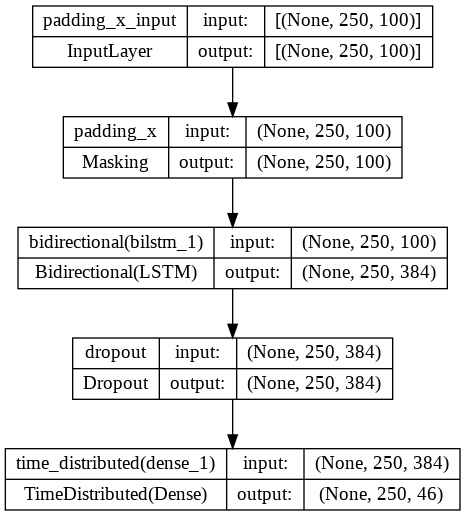

In [ ]:
plot_model(tuner_bilstm.get_best_models()[0], show_shapes=True, show_layer_names=True)

### Model 2: Bidirectional GRU + Dense layer 

In [ ]:
# Hyperparameter optimization using random search
tuner_bigru = RandomSearch(BiGRU, objective = Objective('val_compute_f1', direction = 'max'), max_trials = 4, overwrite = True, seed = 42)
tuner_bigru.search(X_train, y_train, epochs = 10, validation_data = (X_val, y_val))

params_bigru = tuner_bigru.get_best_hyperparameters()[0]

print()
print(f"Hyper parameter tuning completed.\n" 
      f"-------------------------------------\n" 
      f"The best rate found for Dropout layer is {params_bigru.get('dropout')}.\n" 
      f"The best  number of units  found for LSTM layer is {params_bigru.get('units')}.\n" 
      f"The optimal learning rate for the optimizer is {params_bigru.get('learning_rate')}.")

Trial 4 Complete [00h 00m 29s]
val_compute_f1: 0.1927943229675293

Best val_compute_f1 So Far: 0.4702557921409607
Total elapsed time: 00h 01m 56s

Hyper parameter tuning completed.
-------------------------------------
The best rate found for Dropout layer is 0.0.
The best  number of units  found for LSTM layer is 192.
The optimal learning rate for the optimizer is 0.001.


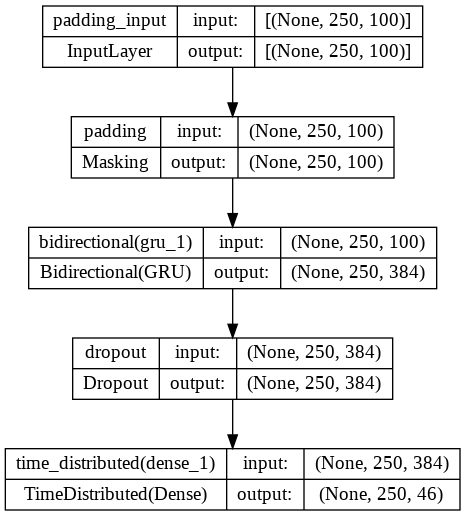

In [ ]:
plot_model(tuner_bigru.get_best_models()[0], show_shapes=True, show_layer_names=True)

### Model 3:  Two Bidirectional LSMT + Dense layer 

In [ ]:
# Hyperparameter optimization using random search
# increased number of search epochs because this model performed very poorly
tuner_double_bilstm = RandomSearch(double_BiLSTM, objective = Objective('val_compute_f1', direction = 'max'), max_trials = 4, overwrite = True)
tuner_double_bilstm.search(X_train, y_train, epochs = 15, validation_data = (X_val, y_val))

params_double_bilstm = tuner_double_bilstm.get_best_hyperparameters()[0]

print()
print(f"Hyper parameter tuning completed.\n" 
      f"-------------------------------------\n"
      f"The best number of units found for the LSTM layer is {params_double_bilstm.get('units')}.\n" 
      f"The best rate found for  Dropout layer is {params_double_bilstm.get('dropout')}.\n" 
      f"The best number of units found for the second LSTM layer is {params_double_bilstm.get('units2')}.\n" 
      f"The best learning rate found for the optimizer is {params_double_bilstm.get('learning_rate')}.")

Trial 4 Complete [00h 01m 38s]
val_compute_f1: 0.02664463222026825

Best val_compute_f1 So Far: 0.2359057366847992
Total elapsed time: 00h 06m 07s

Hyper parameter tuning completed.
-------------------------------------
The best number of units found for the LSTM layer is 128.
The best rate found for  Dropout layer is 0.30000000000000004.
The best number of units found for the second LSTM layer is 192.
The best learning rate found for the optimizer is 0.001.


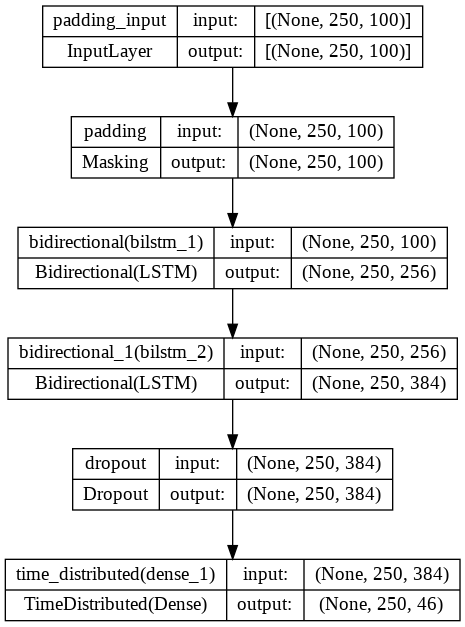

In [ ]:
plot_model(tuner_double_bilstm.get_best_models()[0], show_shapes=True, show_layer_names=True)

### Model 4: Bidirectional LSMT + two Dense layer 

In [ ]:
# Hyperparameter optimization using random search
tuner_bilstm_double_dense = RandomSearch(bilstm_double_dense, objective=Objective('val_compute_f1', direction='max'), max_trials=3, seed=42, overwrite=True)
tuner_bilstm_double_dense.search(X_train, y_train, epochs = 10, validation_data = (X_val, y_val))

params_bilstm_double_dense = tuner_bilstm_double_dense.get_best_hyperparameters()[0]

print()
print(f"Hyper parameter tuning completed.\n" 
      f"-------------------------------------\n"
      f"The best rate found for the first Dropout layer is {params_bilstm_double_dense.get('dropout_1')}.\n" 
      f"The best rate found for the second Dropout layer is {params_bilstm_double_dense.get('dropout_2')}.\n" 
      f"The best number of units for the LSTM layer is {params_bilstm_double_dense.get('units')}.\n" 
      f"The best number of units found for the second LSTM layer is {params_bilstm_double_dense.get('units2')}.\n" 
      f"The best learning rate found for the optimizer is {params_bilstm_double_dense.get('learning_rate')}.")

Trial 3 Complete [00h 00m 31s]
val_compute_f1: 0.22470912337303162

Best val_compute_f1 So Far: 0.5915235280990601
Total elapsed time: 00h 01m 29s

Hyper parameter tuning completed.
-------------------------------------
The best rate found for the first Dropout layer is 0.0.
The best rate found for the second Dropout layer is 0.1.
The best number of units for the LSTM layer is 192.
The best number of units found for the second LSTM layer is 128.
The best learning rate found for the optimizer is 0.01.


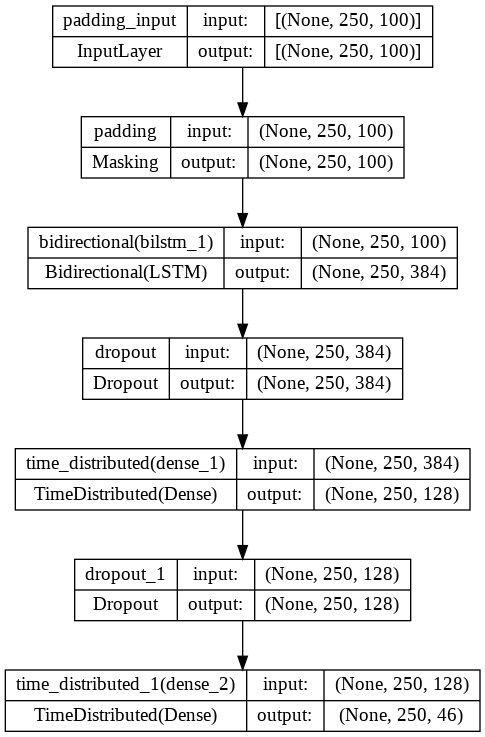

In [ ]:
plot_model(tuner_bilstm_double_dense.get_best_models()[0], show_shapes=True, show_layer_names=True)

##  3.3 Model training

In [ ]:
epochs_training = 100
batch_size_training = 64
callbacks_training = [keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=10, mode="max", restore_best_weights=True)]

### Model 1: Bidirectional LSTM + Dense layer 


Using accuracy for early stopping because it is not really possibile to gauge F1-score  on  mini-batches.

In [ ]:
# Train the best model for 100 epochs
best_bilstm = tuner_bilstm.hypermodel.build(params_bilstm)
best_bilstm.fit(X_train, y_train, epochs=epochs_training,batch_size=batch_size_training ,validation_data=(X_val, y_val),callbacks=callbacks_training)
best_bilstm.save('models/bilstm.h5')

Epoch 1/100
31/31 [==============================] - 11s 129ms/step - loss: 2.3969 - categorical_accuracy: 0.1651 - compute_f1: 0.0215 - val_loss: 1.2482 - val_categorical_accuracy: 0.1974 - val_compute_f1: 0.0252
Epoch 2/100
31/31 [==============================] - 1s 35ms/step - loss: 0.7765 - categorical_accuracy: 0.2656 - compute_f1: 0.0431 - val_loss: 0.4477 - val_categorical_accuracy: 0.3345 - val_compute_f1: 0.0624
Epoch 3/100
31/31 [==============================] - 1s 34ms/step - loss: 0.3286 - categorical_accuracy: 0.3933 - compute_f1: 0.0829 - val_loss: 0.2491 - val_categorical_accuracy: 0.4614 - val_compute_f1: 0.1051
Epoch 4/100
31/31 [==============================] - 1s 34ms/step - loss: 0.2176 - categorical_accuracy: 0.5058 - compute_f1: 0.1447 - val_loss: 0.1990 - val_categorical_accuracy: 0.5337 - val_compute_f1: 0.1692
Epoch 5/100
31/31 [==============================] - 1s 35ms/step - loss: 0.1859 - categorical_accuracy: 0.5686 - compute_f1: 0.1950 - val_loss: 0.179

### Model 2: Bidirectional GRU + Dense layer 



In [ ]:
# Train the best model for 10 epochs
best_bigru = tuner_bigru.hypermodel.build(params_bigru)
best_bigru.fit(X_train, y_train, epochs=epochs_training,batch_size=batch_size_training ,validation_data=(X_val, y_val),callbacks=callbacks_training)
best_bigru.save('models/bigru.h5')

Epoch 1/100
31/31 [==============================] - 11s 125ms/step - loss: 2.4382 - categorical_accuracy: 0.2509 - compute_f1: 0.0376 - val_loss: 1.3705 - val_categorical_accuracy: 0.3457 - val_compute_f1: 0.0522
Epoch 2/100
31/31 [==============================] - 1s 33ms/step - loss: 0.8729 - categorical_accuracy: 0.4391 - compute_f1: 0.0881 - val_loss: 0.5032 - val_categorical_accuracy: 0.5243 - val_compute_f1: 0.1629
Epoch 3/100
31/31 [==============================] - 1s 33ms/step - loss: 0.3508 - categorical_accuracy: 0.5561 - compute_f1: 0.1930 - val_loss: 0.2471 - val_categorical_accuracy: 0.5740 - val_compute_f1: 0.2133
Epoch 4/100
31/31 [==============================] - 1s 34ms/step - loss: 0.2039 - categorical_accuracy: 0.6304 - compute_f1: 0.2741 - val_loss: 0.1791 - val_categorical_accuracy: 0.6318 - val_compute_f1: 0.2763
Epoch 5/100
31/31 [==============================] - 1s 33ms/step - loss: 0.1631 - categorical_accuracy: 0.6729 - compute_f1: 0.3250 - val_loss: 0.157

### Model 3:  Two Bidirectional LSTM + Dense layer 

In [ ]:
# Train the best model for 10 epochs
best_double_bilstm= tuner_double_bilstm.hypermodel.build(params_double_bilstm)
best_double_bilstm.fit(X_train, y_train, epochs=epochs_training,batch_size=batch_size_training ,validation_data=(X_val, y_val),callbacks=callbacks_training)
best_double_bilstm.save('models/double_bilstm.h5')

Epoch 1/100
31/31 [==============================] - 20s 218ms/step - loss: 6.7828 - categorical_accuracy: 0.1422 - compute_f1: 0.0186 - val_loss: 3.2700 - val_categorical_accuracy: 0.1768 - val_compute_f1: 0.0160
Epoch 2/100
31/31 [==============================] - 2s 55ms/step - loss: 1.8649 - categorical_accuracy: 0.1723 - compute_f1: 0.0215 - val_loss: 0.9034 - val_categorical_accuracy: 0.1801 - val_compute_f1: 0.0146
Epoch 3/100
31/31 [==============================] - 2s 53ms/step - loss: 0.5873 - categorical_accuracy: 0.1786 - compute_f1: 0.0229 - val_loss: 0.3832 - val_categorical_accuracy: 0.1903 - val_compute_f1: 0.0186
Epoch 4/100
31/31 [==============================] - 2s 54ms/step - loss: 0.3242 - categorical_accuracy: 0.1899 - compute_f1: 0.0267 - val_loss: 0.2869 - val_categorical_accuracy: 0.1930 - val_compute_f1: 0.0228
Epoch 5/100
31/31 [==============================] - 2s 55ms/step - loss: 0.2751 - categorical_accuracy: 0.2019 - compute_f1: 0.0303 - val_loss: 0.265

### Model 4: Bidirectional LSMT + two Dense layer 

In [ ]:
# Train the best model for 10 epochs
best_bilstm_double_dense = tuner_bilstm_double_dense.hypermodel.build(params_bilstm_double_dense)
best_bilstm_double_dense.fit(X_train, y_train, epochs=epochs_training,batch_size=batch_size_training ,validation_data=(X_val, y_val),callbacks=callbacks_training)
best_bilstm_double_dense.save('models/bilstm_double_dense.h5')

Epoch 1/100
31/31 [==============================] - 11s 125ms/step - loss: 0.7176 - categorical_accuracy: 0.2248 - compute_f1: 0.0322 - val_loss: 0.2642 - val_categorical_accuracy: 0.4419 - val_compute_f1: 0.1050
Epoch 2/100
31/31 [==============================] - 1s 36ms/step - loss: 0.1775 - categorical_accuracy: 0.5763 - compute_f1: 0.2203 - val_loss: 0.1210 - val_categorical_accuracy: 0.7228 - val_compute_f1: 0.3862
Epoch 3/100
31/31 [==============================] - 1s 36ms/step - loss: 0.1101 - categorical_accuracy: 0.7371 - compute_f1: 0.3955 - val_loss: 0.0987 - val_categorical_accuracy: 0.7593 - val_compute_f1: 0.4508
Epoch 4/100
31/31 [==============================] - 1s 37ms/step - loss: 0.0926 - categorical_accuracy: 0.7773 - compute_f1: 0.4591 - val_loss: 0.0809 - val_categorical_accuracy: 0.8095 - val_compute_f1: 0.5110
Epoch 5/100
31/31 [==============================] - 1s 36ms/step - loss: 0.0810 - categorical_accuracy: 0.8077 - compute_f1: 0.4959 - val_loss: 0.076

Evaluating the performance of the models on the validation set.

F1 score

In [ ]:
print(f"- F1 score of BiLSTM model: {round(max(best_bilstm.history.history['val_compute_f1']),4)}")
print(f"- F1 score of BiGRU model: {round(max(best_bigru.history.history['val_compute_f1']),4)}")
print(f"- F1 score of double BiLSTM: {round(max(best_double_bilstm.history.history['val_compute_f1']),4)}")
print(f"- F1 score of BiLSTM double dense model: {round(max(best_bilstm_double_dense.history.history['val_compute_f1']),4)}")

- F1 score of BiLSTM model: 0.5796
- F1 score of BiGRU model: 0.5797
- F1 score of double BiLSTM: 0.4573
- F1 score of BiLSTM double dense model: 0.6643


Accuracy

In [ ]:
print(f"- Accuracy of BiLSTM model: {round(max(best_bilstm.history.history['val_categorical_accuracy']),4)}")
print(f"- Accuracy of BiGRU model: {round(max(best_bigru.history.history['val_categorical_accuracy']),4)}")
print(f"- Accuracy of double BiLSTM: { round(max(best_double_bilstm.history.history['val_categorical_accuracy']),4)}")
print(f"- Accuracy of BiLSTM double dense model: {round(max(best_bilstm_double_dense.history.history['val_categorical_accuracy']),4)}")

- Accuracy of BiLSTM model: 0.8353
- Accuracy of BiGRU model: 0.8366
- Accuracy of double BiLSTM: 0.751
- Accuracy of BiLSTM double dense model: 0.8889


From the F1-score and the accuracy on the validation set the BiGRU and BiLSTM are performing really near each other, with the BiGRU having a slight edge.

From this we can see the double BiLSTM is having some problems, it has a not accuracy not really that much lower from other models(6% less than BiGRU and BiLSTM), but is performing worse on the F1 Score. 

This is due to the overfitting of the double BiLSTM which is a network more complex than the problem at hand. 

Given that we know that the dataset is unbalenced towards some tags we can see that the other models are less prone to this kind of issue in the dataset whereas the double BiLSTM is really being affected by it and it is showing in the F1-score, clearly the double BiLSTM is making more errors on some classes than others.

The best two models chosen are:
1. BiLSTM double dense
2. BiGRU

### History of the training

In [ ]:
def plot_accuracy_loss_f1(hist):
    plt.rcParams["figure.figsize"] = (15,20)
    fig, ax1 = plt.subplots(3,1)
    fig.suptitle('Training history')
    ax1[0].plot(hist.history['categorical_accuracy'])
    ax1[0].plot(hist.history['val_categorical_accuracy'])
    ax1[0].set_title("model accuracy")
    ax1[0].set_ylabel('accuracy')
    ax1[0].set_xlabel('epoch')
    ax1[0].legend(['train', 'val'], loc='best')
    

    ax1[1].plot(hist.history['loss'])
    ax1[1].plot(hist.history['val_loss'])
    ax1[1].set_title("model loss")
    ax1[1].set_ylabel('loss')
    ax1[1].set_xlabel('epoch')
    ax1[1].legend(['train', 'val'], loc='best')

    ax1[2].plot(hist.history['compute_f1'])
    ax1[2].plot(hist.history['val_compute_f1'])
    ax1[2].set_title("f1 score")
    ax1[2].set_ylabel('f1 score')
    ax1[2].set_xlabel('epoch')
    ax1[2].legend(['train', 'val'], loc='best')
    plt.show()

### History of the training for the best first model: *best_bilstm_double_dense*





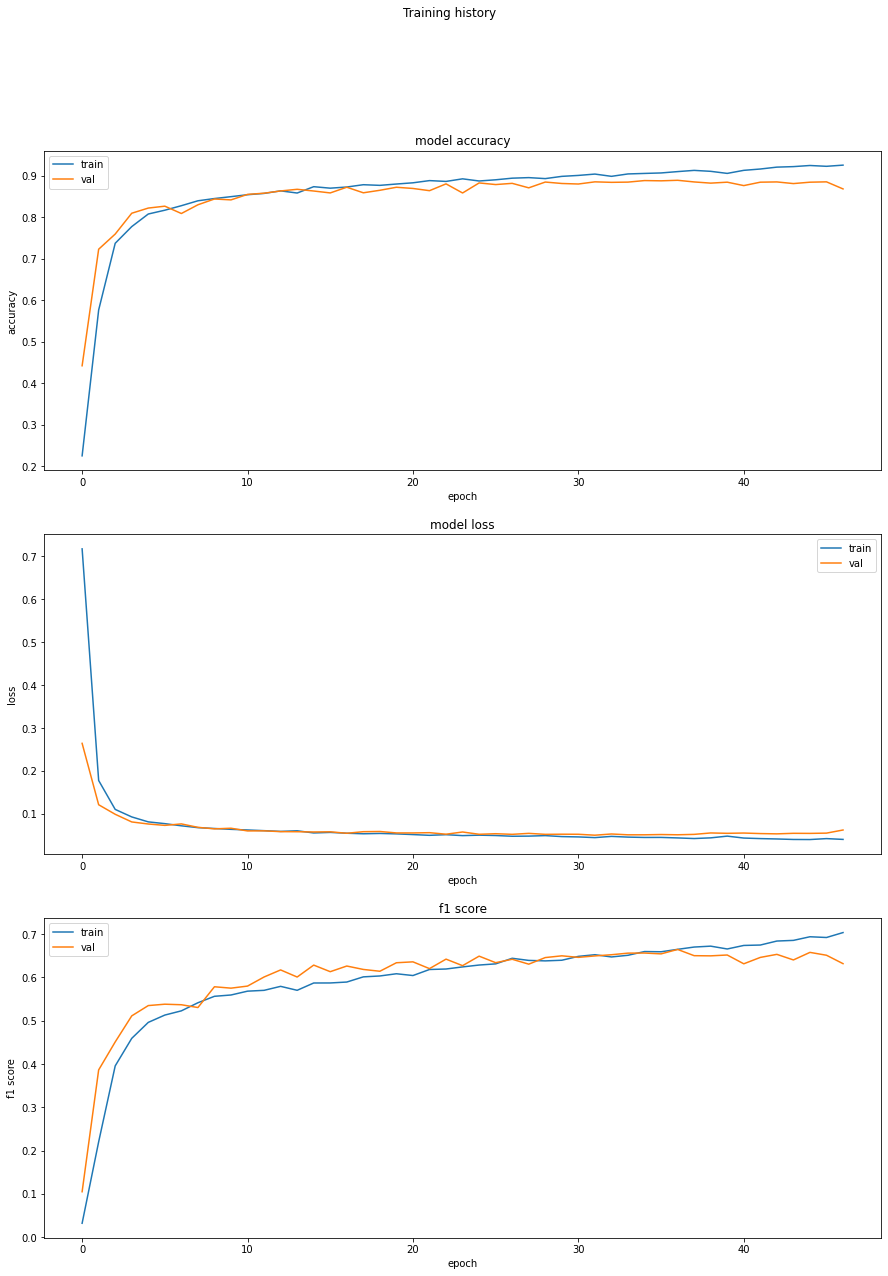

In [ ]:
plot_accuracy_loss_f1(best_bilstm_double_dense.history)

### History of the training for the  second best model: *best_bigru*

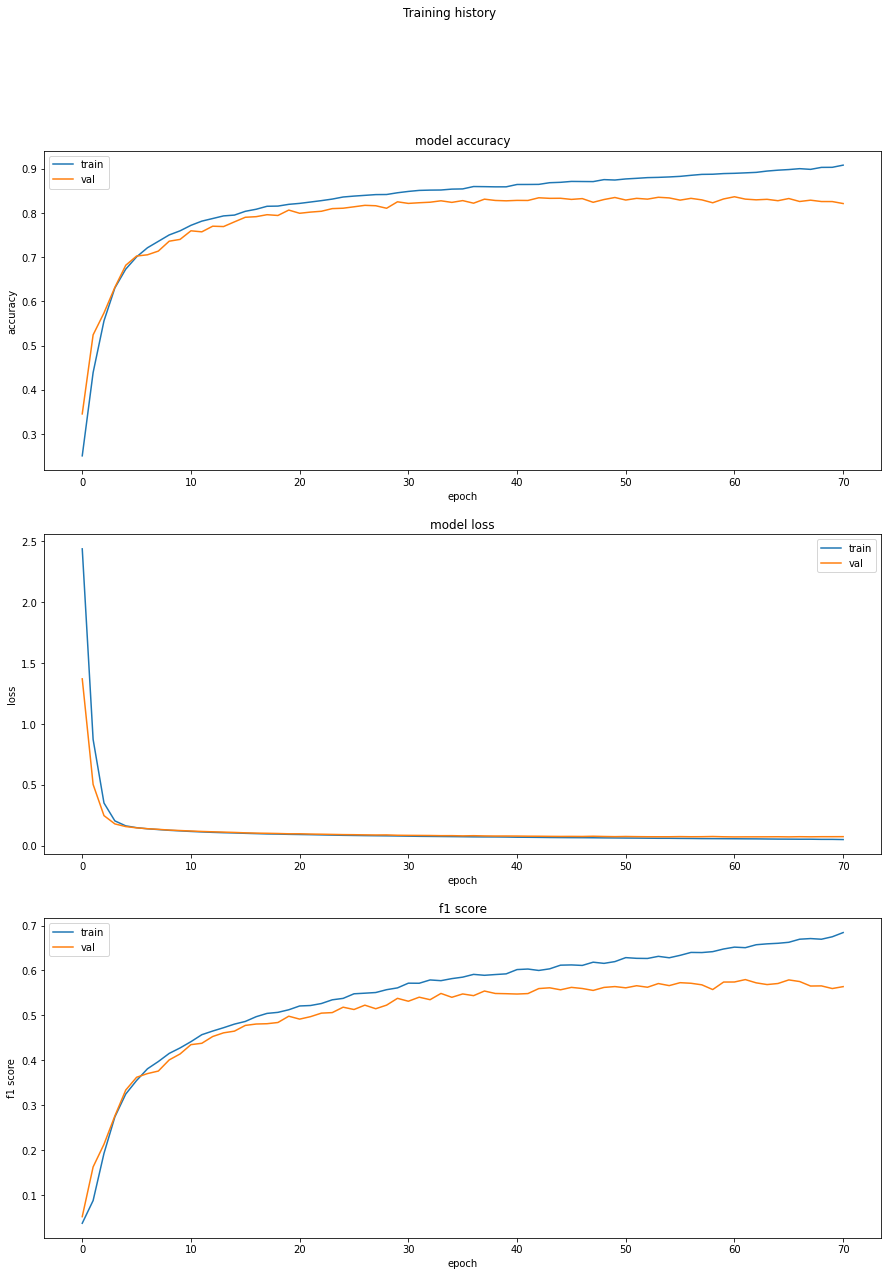

In [ ]:
plot_accuracy_loss_f1(best_bigru.history)

We can see the second best model (i.e. the BiGRU) is overfitting whereas the first one is still overfitting but is less prone to it, in fact we can see that the f1-scores between train and val are more near each other.

## Model Evaluation

Loading the two best performing models

In [ ]:
# Select the two best models based on the f1-score on validation set
best_first_model = load_model(os.getcwd() + '/models/bilstm_double_dense.h5',compile=False)

best_second_model = load_model(os.getcwd() + '/models/bigru.h5',compile=False)

# Compile the models
best_first_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['val_categorical_accuracy','val_compute_f1'])
best_second_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['val_categorical_accuracy','val_compute_f1'])

Predicting labels for the test set

In [ ]:
first_pred_labels = best_first_model.predict(X_test) # bilstm with double dense layer
second_pred_labels = best_second_model.predict(X_test) # bigru

21/21 [==============================] - 2s 7ms/step


### Final Error analysis

* Performance on: 
    * the most frequent classes  
    * the less frequent classes 

* precision  

* recall 



For the evaluation we need to get rid of tags representing symbols and punctuation, so we have to extract the correct tags that has to be involved in evaluation process. The metric chosen for the evaluation is the macro f1, computed token by token. Indeed, since the output of the network is one-hot encoded we had to collapse the list into an one and only one numpy array, which contains all the tokens without considering sentences.

#### Analyzing some misclassified example sentence from the test set

We now retrieve some sample sentences from the test set to show some errors.

In [ ]:
def predict_and_inverse_labels(idx,model,X_sents,y_tags):
    sample_tags = y_tags[idx]
    sentence = X_sents[idx]
    y_pred = model.predict(np.array([X_test[idx]]))
    whole_pred =  np.concatenate(y_pred) # flatten the array of the predictions
    above_threshold = whole_pred[np.std(whole_pred, axis=1) > 0.05] # get predicted values above 0.05
    pred_tags = sort_tags[np.argmax(above_threshold,axis=1)] # get the biggest among these predicted values
    y_true = ohe.inverse_transform(sample_tags[sample_tags.any(1)]).T  # inverse transform the label corresponding to the argmax
    
    return sentence,pred_tags, np.concatenate(y_true)

In [ ]:
sample_sentence, y_pred, y_gold = predict_and_inverse_labels(12,best_second_model,X_test_sents,y_test)

1/1 [==============================] - 0s 22ms/step


In [ ]:
print(sample_sentence)
print()
print(y_gold)
print()
print(y_pred)

['in' 'composite' 'trading' 'on' 'the' 'new' 'york' 'stock' 'exchange' ','
 'telerate' 'shares' 'closed' 'at' '$' '19.50' ',' 'up' '12.5' 'cents' '.']

['IN' 'JJ' 'NN' 'IN' 'DT' 'NNP' 'NNP' 'NNP' 'NNP' ',' 'NNP' 'NNS' 'VBD'
 'IN' '$' 'CD' ',' 'RB' 'CD' 'NNS' '.']

['IN' 'CD' 'NN' 'IN' 'DT' 'NNP' 'NNP' 'NNP' 'NN' ',' 'NNP' 'NNP' 'VBG'
 'IN' '$' 'CD' ',' 'RB' 'CD' 'NNS' '.']


In [ ]:
sample_sentence1, y_pred1, y_gold1 = predict_and_inverse_labels(28,best_first_model,X_test_sents,y_test)

1/1 [==============================] - 0s 21ms/step


In [ ]:
print(sample_sentence1)
print()
print(y_gold1)
print()
print(y_pred1)

['for' 'the' 'year' ',' 'bolstered' 'by' 'the' 'introduction' 'of' 'the'
 'colorliner' 'newspaper-printing' 'press' ',' 'graphics' 'earnings'
 'almost' 'doubled' '.']

['IN' 'DT' 'NN' ',' 'VBN' 'IN' 'DT' 'NN' 'IN' 'DT' 'NNP' 'NN' 'NN' ','
 'NNS' 'NNS' 'RB' 'VBD' '.']

['IN' 'DT' 'NN' ',' 'VBP' 'IN' 'DT' 'NN' 'IN' 'DT' 'NNP' 'NNP' 'NN' ','
 'NNS' 'NNS' 'RB' 'VBP' '.']


In [ ]:
def get_errors(sentence, prediction, ground_truth, tags):
    """
    Given a list of predicted tokens and their associated truths,
    print the type of misclassifications of the model that produced the,
    where tags names are extracted from the given vocabulary
    """
    pred_tag = prediction[prediction != ground_truth]
    real_tag = ground_truth[prediction != ground_truth]
    wrong_words = sentence[prediction != ground_truth]
    for pred, real, word in zip(pred_tag, real_tag, wrong_words):
        print(f"The tag {real} was marked as {pred} ==> word misclassified: {word}")

In [ ]:
get_errors(sample_sentence,y_pred,y_gold,sort_tags)

The tag JJ was marked as CD ==> word misclassified: composite
The tag NNP was marked as NN ==> word misclassified: exchange
The tag NNS was marked as NNP ==> word misclassified: shares
The tag VBD was marked as VBG ==> word misclassified: closed


In [ ]:
get_errors(sample_sentence1,y_pred1,y_gold1,sort_tags)

The tag VBN was marked as VBP ==> word misclassified: bolstered
The tag NN was marked as NNP ==> word misclassified: newspaper-printing
The tag VBD was marked as VBP ==> word misclassified: doubled


We can see the errors from the two examples above are mostly connected to similar tags.



* For example in the second sentence, which was classified by the best first model:
    * The model wrongly classified the word ***doubled*** which has the tag *VBD* (*Verb, past tense*) which was tagged as *VBP* (*Verb, non-3rd person singular present*) therefore it seems the models seems to be confusing the present with the past tense. This has also happened in the prediction of the first sentence. 

    * The word ***press*** was wrongly classified as a NNP which is a *Proper noun, singular*, instead its tag was NN (	Noun, singular or mass). This is due to the lowercasing which reduced the number of OOV but lead to some error on other cases.
    * Same for the word ***shares***

    * The word ***newspaper-printing*** was wrongly classified because it is an OOV word ( many OOV are compund words due to the hypen)


## Confusion matrix

In [ ]:
def reverse_ohe(labels):
    """Reverse transform the one hot encoding of a sentence 
     and ignore the padding through the use of "any" from the numpy library 
     """
    return np.array([ohe.inverse_transform(doc[doc.any(1)]) for doc in labels], dtype=object)

In [ ]:
def reverse_pred(labels):
    """
    In this function we  fill a 3-d array (pred) with ones in the indices (i,j)
    corresponding to the argmax of the predicted POS tag for the token. This is 
    need to get the one hot encoding corresponding from the prediction.
    """
    n_classes = labels.shape[2]
    labels = np.array([doc[np.std(doc, axis=1) > 0.05] for doc in labels], dtype=object)
    pred = np.zeros((len(labels), max([len(doc) for doc in labels]), n_classes))
    for i, doc in enumerate(labels):
        for j, token in enumerate(doc):
            pred[i, j, np.argmax(token)] = 1
    return reverse_ohe(pred)

In [ ]:
def compare(model, X, y):
    """
    In this function we create a 1-d version array of the true and the labels.
    This is needed to perform the test evaluation on the POS tags.
    """ 

    raw_pred = model.predict(X)
    y_true = reverse_ohe(y)
    y_pred = reverse_pred(raw_pred)

    l_y_true = []
    l_y_pred = []
    for predicted, ground_truth in zip(y_pred, y_true):
        for pred_word, true_word in zip (predicted, ground_truth):
            l_y_pred.append(pred_word)
            l_y_true.append(true_word)
    return l_y_true, l_y_pred

In [ ]:
y_true , y_pred = compare(best_first_model,X_test,y_test)

21/21 [==============================] - 0s 8ms/step


In [ ]:
def return_comparison(model, X, y):

    raw_pred = model.predict(X)
    y_true = reverse_ohe(y)
    y_pred = reverse_pred(raw_pred)

    l_y_true = []
    l_y_pred = []
    for predicted, ground_truth in zip(y_pred, y_true):
        for token_predicted, token_true in zip (predicted, ground_truth):
            l_y_pred.append(token_predicted)
            l_y_true.append(token_true)
    return l_y_true, l_y_pred

Computing the tags to remove (punctuation and symbols) and then removing them.

In [ ]:
punct_symbol_tags=sort_tags[indices]
excluded_symbols = np.array(sorted(set(sort_tags) - set(punct_symbol_tags)))

In [ ]:
def evaluate(model, X, y, labels):
    """
    computes the f-score and the confusion matrix of a given model on a test set
    """
    # show confusion matrix
    y_true, y_pred = compare(model, X, y)
    conf_matr = confusion_matrix(y_true, y_pred, labels = labels)
    displayed = ConfusionMatrixDisplay(conf_matr, display_labels = labels)
    fig, ax = plt.subplots(figsize = (20,18))
    displayed.plot(ax = ax)

    print("\nF1 score:\n-------------------------------")
    print(round(f1_score(y_true, y_pred, labels = labels, average = 'macro', zero_division = 0),4))
    print("\nAccuracy score:\n-------------------------------")
    print(round(accuracy_score(y_true, y_pred),4),"\n")

### Confusion matrix

#### Best first model

21/21 [==============================] - 0s 8ms/step

F1 score:
-------------------------------
0.7285

Accuracy score:
-------------------------------
0.8957 



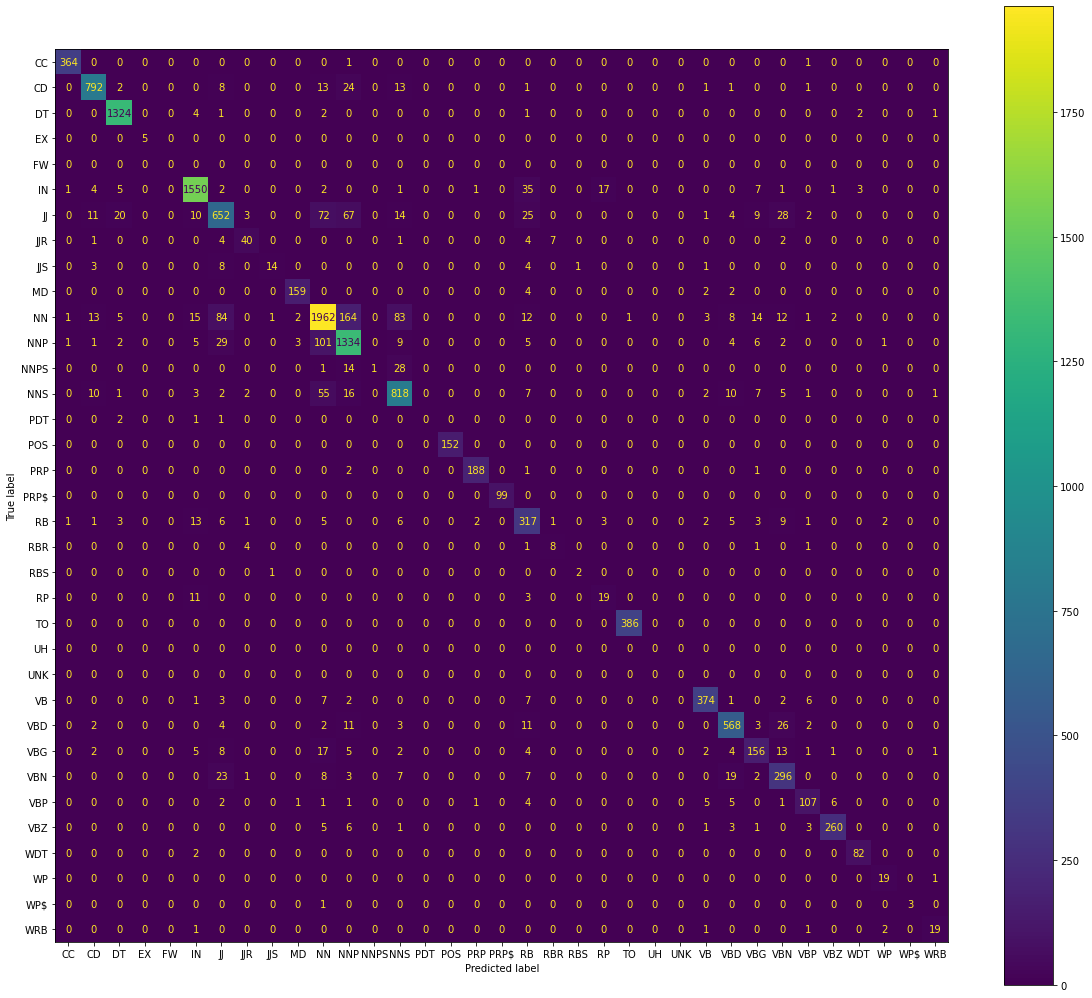

In [ ]:
evaluate(best_first_model,X_test,y_test,excluded_symbols)

#### Second best model

21/21 [==============================] - 0s 8ms/step

F1 score:
-------------------------------
0.5377

Accuracy score:
-------------------------------
0.8068 



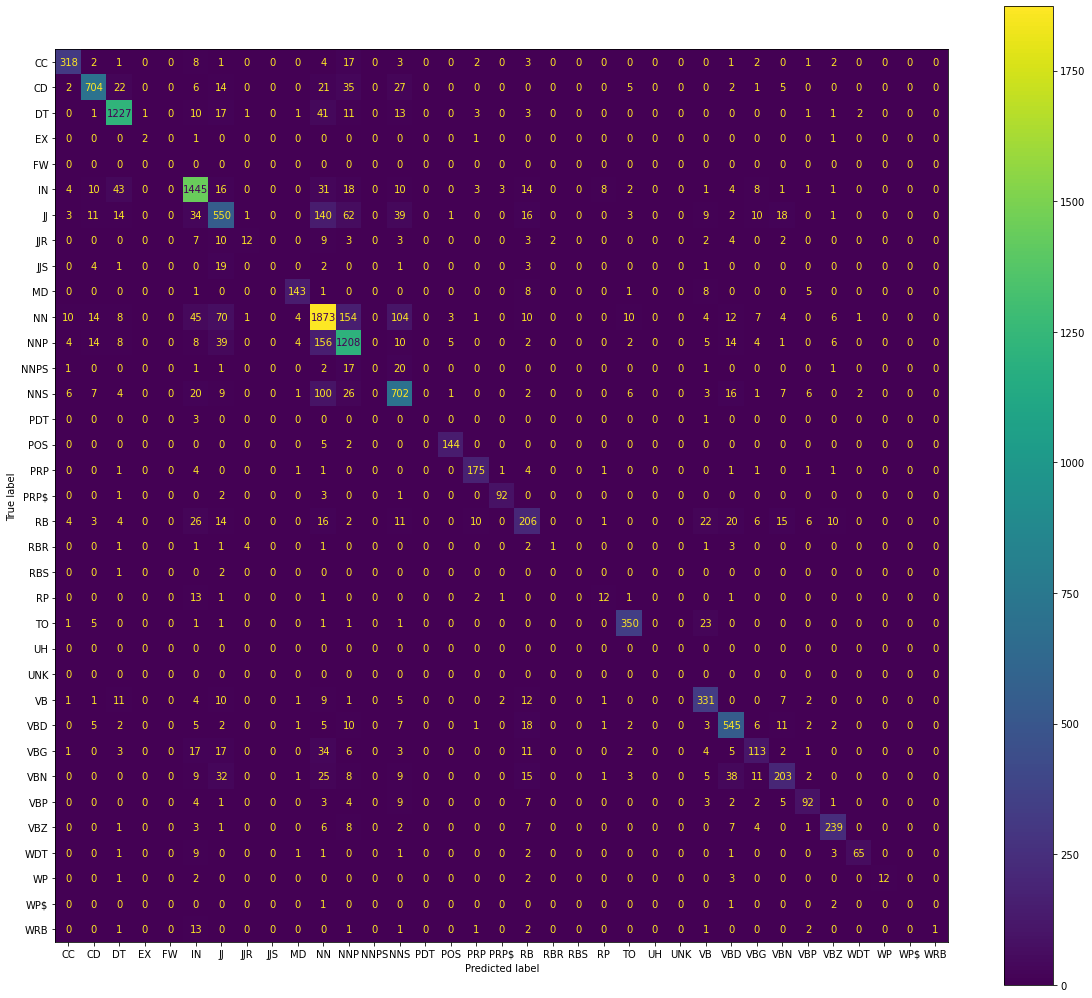

In [ ]:
evaluate(best_second_model,X_test,y_test,excluded_symbols)

Showing classification report in order to display the precision and recall among classes

In [ ]:
def report(model, X, y, sorted_by=None, ascending=True):
  """
  Show classification report using only classes in names
  """
  ground_truth, predicted = compare(model, X, y)
  class_report =  classification_report(ground_truth, predicted, output_dict=True, zero_division=0)
  
  # global performance
  keys = ['weighted avg', 'accuracy', 'macro avg']
  global_dict = {key: class_report[key] for key in keys}
  for key in keys:
    del class_report[key]

  df = pd.DataFrame.from_dict(class_report).transpose().round(2)
  if sorted_by:
    df.sort_values(by=sorted_by, ascending=ascending, inplace=True)
  print(df)

  print("\n\n")

  df_glob = pd.DataFrame.from_dict(global_dict).transpose().round(2)
  print(df_glob)

In [ ]:
report(best_first_model, X_test, y_test, sorted_by=['f1-score'], ascending=False)

21/21 [==============================] - 0s 12ms/step
       precision  recall  f1-score  support
$           1.00    1.00      1.00    209.0
:           1.00    1.00      1.00     56.0
TO          1.00    1.00      1.00    386.0
PRP$        1.00    1.00      1.00     99.0
POS         1.00    1.00      1.00    152.0
EX          1.00    1.00      1.00      5.0
``          1.00    1.00      1.00     73.0
,           1.00    1.00      1.00    787.0
CC          0.99    0.99      0.99    366.0
.           0.99    1.00      0.99    637.0
PRP         0.98    0.98      0.98    192.0
DT          0.97    0.99      0.98   1335.0
-LRB-       1.00    0.94      0.97     18.0
MD          0.96    0.95      0.96    167.0
WDT         0.94    0.98      0.96     84.0
IN          0.96    0.95      0.95   1630.0
VBZ         0.96    0.93      0.95    280.0
VB          0.94    0.93      0.94    403.0
CD          0.94    0.92      0.93    858.0
''          1.00    0.87      0.93     70.0
VBD         0.90    0.

In [ ]:
report(best_second_model, X_test, y_test, sorted_by=['f1-score'], ascending=False)

21/21 [==============================] - 0s 12ms/step
       precision  recall  f1-score  support
``          0.97    0.99      0.98     73.0
:           0.98    0.93      0.95     56.0
$           0.93    0.96      0.95    209.0
,           0.95    0.95      0.95    787.0
POS         0.94    0.95      0.94    152.0
''          0.97    0.91      0.94     69.0
.           0.88    0.99      0.94    572.0
PRP$        0.93    0.93      0.93     99.0
DT          0.90    0.92      0.91   1335.0
TO          0.90    0.91      0.91    386.0
PRP         0.86    0.91      0.89    192.0
MD          0.90    0.86      0.88    167.0
IN          0.85    0.89      0.87   1630.0
CC          0.88    0.87      0.87    366.0
VBZ         0.86    0.85      0.86    280.0
CD          0.89    0.82      0.85    857.0
VBD         0.79    0.86      0.83    633.0
WDT         0.88    0.77      0.82     84.0
VB          0.77    0.82      0.80    403.0
NNP         0.75    0.80      0.78   1504.0
NN          0.75    0.

* verify and discuss if the results on the test sets are coherent with those on the validation set

* analyze the errors done by your model 


* try to understand which may be the causes and think about how to improve it.